Link to data source: https://www.kaggle.com/datasets/ananthr1/weather-prediction?datasetId=1868601

# Bài toán: Dự đoán thời tiết trong ngày từ năm 2012 đến 2015

## Xử lý dữ liệu

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import warnings


Đọc dữ liệu đầu vào

In [132]:
data = pd.read_csv('seattle-weather.csv')


In [133]:
data.head()


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


### Exploratory Data Analysis

Biểu đồ thể hiện số lượng các loại thời tiết xảy ra

<AxesSubplot:xlabel='weather', ylabel='count'>

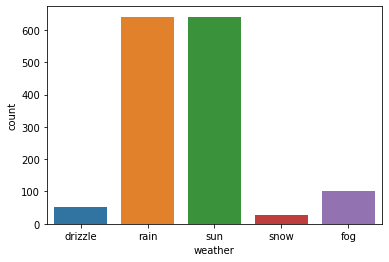

In [134]:
sns.countplot(data=data, x='weather')

In [135]:
total = data['weather'].count()
rain = (data['weather']=="rain").sum()
sun = (data['weather']=="sun").sum()
fog = (data['weather']=="fog").sum()
drizzle = (data['weather']=="drizzle").sum()
snow = (data['weather']=="snow").sum()

print(data['weather'].value_counts())
print("Rain: ", rain)
print("Fog: ", fog)
print("Drizzle: ", drizzle)
print("Snow: ", snow)

rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: weather, dtype: int64
Rain:  641
Fog:  101
Drizzle:  53
Snow:  26


Biểu đồ thể hiện sự phụ thuộc giữa cột **Weather** và các cột khác

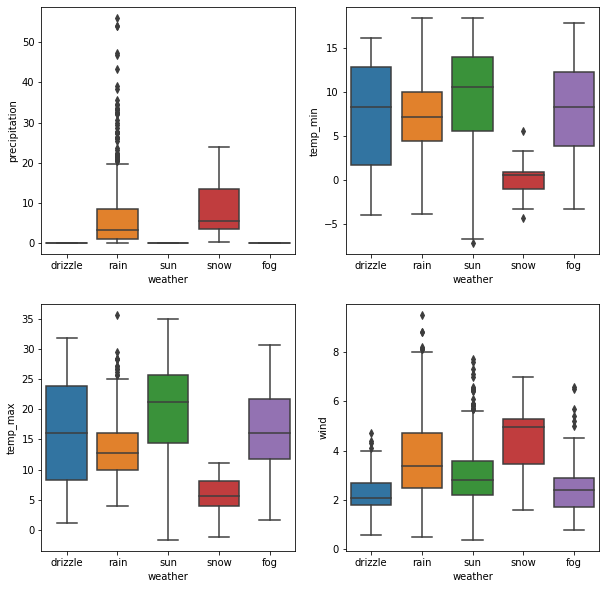

In [136]:
fig,axes = plt.subplots(2,2, figsize=(10,10))
cols = ['precipitation', 'temp_max', 'temp_min', 'wind']
for i in range(4):
    sns.boxplot(x='weather', y=cols[i], data=data, ax=axes[i%2,i//2])

Tiến hành bỏ cột **Date**

In [137]:
data = data.drop(['date'], axis=1)

Chuyển dữ liệu cột Weather về dạng: Rain: 0, Sun: 1, Fog: 2, Drizzle: 3, Snow: 4

In [138]:
data['weather'] = data['weather'].replace(
    {'rain': 0, 'sun': 1, 'fog': 2, 'drizzle': 3, 'snow': 4})

data.head()


,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,3
1,10.9,10.6,2.8,4.5,0
2,0.8,11.7,7.2,2.3,0
3,20.3,12.2,5.6,4.7,0
4,1.3,8.9,2.8,6.1,0


Lựa chọn các cột dùng để dự đoán dữ liệu cho cột **Weather**

### Chia tập train và test

In [139]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['weather'], axis=1), data['weather'], test_size=0.3, random_state=1)


### Xử lý ngoại lệ

Hàm xử lý ngoại lệ

In [140]:
def boundary(data, column):
    upper_boundary = data[column].mean() + 3 * data[column].std()
    lower_boundary = data[column].mean() - 3 * data[column].std()
    data.loc[data[column] >= int(upper_boundary), column] = int(upper_boundary)
    data.loc[data[column] <= int(lower_boundary), column] = int(lower_boundary)
    return lower_boundary, upper_boundary


def bridge(data, column):
    IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
    upper_bridge = data[column].quantile(0.75) + 3 * IQR
    lower_bridge = data[column].quantile(0.25) - 3 * IQR
    data.loc[data[column] >= int(upper_bridge), column] = int(upper_bridge)
    data.loc[data[column] <= int(lower_bridge), column] = int(lower_bridge)
    return lower_bridge, upper_bridge


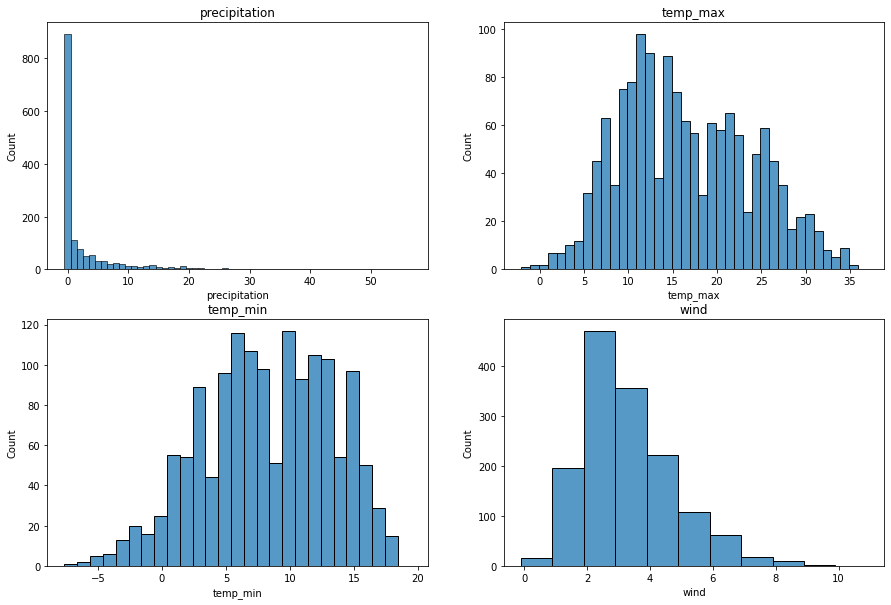

In [141]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(data['precipitation'], discrete=True)
plt.title('precipitation')
plt.subplot(2, 2, 2)
sns.histplot(data['temp_max'], discrete=True)
plt.title('temp_max')
plt.subplot(2, 2, 3)
sns.histplot(data['temp_min'], discrete=True)
plt.title('temp_min')
plt.subplot(2, 2, 4)
sns.histplot(data['wind'], discrete=True)
plt.title('wind')
plt.show()

In [142]:
print('X train:')
print('precipitation: {}'.format(bridge(X_train, 'precipitation')))
print('temp_max: {}'.format(boundary(X_train, 'temp_max')))
print('temp_min: {}'.format(boundary(X_train, 'temp_min')))
print('wind: {}'.format(boundary(X_train, 'wind')))
print('X test:')
print('precipitation: {}'.format(bridge(X_test, 'precipitation')))
print('temp_max: {}'.format(boundary(X_test, 'temp_max')))
print('temp_min: {}'.format(boundary(X_test, 'temp_min')))
print('wind: {}'.format(boundary(X_test, 'wind')))


X train:
precipitation: (-9.0, 12.0)
temp_max: (-5.8232233970784755, 38.626745901970835)
temp_min: (-7.016508440873661, 23.49791744283061)
wind: (-1.0688556655293726, 7.546546467877707)
X test:
precipitation: (-6.8999999999999995, 9.2)
temp_max: (-5.131567497607389, 38.18350371628621)
temp_min: (-6.417583516029779, 22.859496955665314)
wind: (-1.0852994135551381, 7.578237910138281)


## Xây dựng, đánh giá mô hình và dự đoán

### Hàm

Hàm đánh giá độ chính xác mô hình với cross_val_score

In [143]:
def get_accuracy_by_cross_val_score(X: np.array, y: np.array, best_params={}):
    classifier = LogisticRegression() if not len(best_params) else LogisticRegression(
        C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'])
    scores = cross_val_score(
        classifier, X, y, cv=5, scoring='accuracy')
    return scores.mean()


Hàm tìm bộ tham số tốt nhất cho Logistic Regresstion

In [144]:
def get_hyperparameters(X_train, X_test, y_train, y_test):
    # Định nghĩa  model và tham số
    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    penalty = ['none', 'l1', 'l2', 'elasticnet']
    c_values = [100, 10, 1.0, 0.1, 0.01]

    grid = dict(solver=solvers, penalty=penalty, C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid,
                               n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
    grid_result = grid_search.fit(X_train, y_train)

    return grid_result.best_score_, grid_result.best_params_


### Đánh giá độ chính xác của mô hình

Đánh giá độ chính xác của mô hình với tham số mặc định

In [145]:
warnings.filterwarnings('ignore')

accuracy_default_params = round(get_accuracy_by_cross_val_score(data.drop(
    ['weather'], axis=1), data['weather']) * 100, 3)

print("Đánh giá độ chính xác của mô hình với tham số mặc định: {}%".format(
    accuracy_default_params))


Đánh giá độ chính xác của mô hình với tham số mặc định: 84.124%


Tìm bộ tham số tốt nhất cho Logistic Regresstion

In [146]:
warnings.filterwarnings('ignore')

best_score, best_params = get_hyperparameters(X_train, X_test, y_train, y_test)

print("Độ chính xác tốt nhất là: {}\nBộ siêu tham số: {}".format(
    best_score, best_params))


Độ chính xác tốt nhất là: 0.85357573450092
Bộ siêu tham số: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


Đánh giá độ chính xác của mô hình với siêu tham số

In [147]:
accuracy_best_params = round(get_accuracy_by_cross_val_score(data.drop(
    ['weather'], axis=1), data['weather'], best_params) * 100, 3)

print("Đánh giá độ chính xác của mô hình với siêu tham số: {}%".format(
    accuracy_best_params))


Đánh giá độ chính xác của mô hình với siêu tham số: 84.398%


So sánh độ chính xác giữa 2 phương pháp

In [148]:
print("Độ chính xác chênh lệch giữa mô hình với siêu tham số và mô hình với tham số mặc định: {} %".format(
    round((accuracy_best_params - accuracy_default_params), 3)))


Độ chính xác chênh lệch giữa mô hình với siêu tham số và mô hình với tham số mặc định: 0.274 %


Nhận xét:
- Độ chính xác của mô hình với tham số mặc định: **84.124 %**
- Độ chính xác của mô hình với siêu tham số: **84.398 %**
- Sử dụng siêu tham số giúp độ chính xác của mô hình được cải thiện: **0.274 %**

### Thử cải thiện độ chính xác bằng chuẩn hóa dữ liệu

In [149]:
warnings.filterwarnings('ignore')

# Chuẩn hóa dữ liệu
# StandardScaler
standard_scaler = StandardScaler()
new_X_train = standard_scaler.fit_transform(X_train)
new_X_test = standard_scaler.transform(X_test)

best_score, best_params = get_hyperparameters(new_X_train, new_X_test, y_train, y_test)

print("Độ chính xác tốt nhất là: {}\nBộ siêu tham số: {}".format(
    best_score, best_params))

accuracy_best_params = round(get_accuracy_by_cross_val_score(
    data.drop(['weather'], axis=1), data['weather'], best_params) * 100, 3)

print("Đánh giá độ chính xác của mô hình với siêu tham số: {}%".format(
    accuracy_best_params))


Độ chính xác tốt nhất là: 0.85357573450092
Bộ siêu tham số: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Đánh giá độ chính xác của mô hình với siêu tham số: 84.398%


In [150]:
# MinMaxScaler
min_max_scaler = MinMaxScaler()
new_X_train = min_max_scaler.fit_transform(X_train)
new_X_test = min_max_scaler.transform(X_test)

best_score, best_params = get_hyperparameters(new_X_train, new_X_test, y_train, y_test)

print("Độ chính xác tốt nhất là: {}\nBộ siêu tham số: {}".format(
    best_score, best_params))

accuracy_best_params = round(get_accuracy_by_cross_val_score(
    data.drop(['weather'], axis=1), data['weather'], best_params) * 100, 3)

print("Đánh giá độ chính xác của mô hình với siêu tham số: {}%".format(
    accuracy_best_params))

Độ chính xác tốt nhất là: 0.8529253125198297
Bộ siêu tham số: {'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}
Đánh giá độ chính xác của mô hình với siêu tham số: 84.398%


In [151]:
# RobustScaler
robust_scaler = RobustScaler()
new_X_train = robust_scaler.fit_transform(X_train)
new_X_test = robust_scaler.transform(X_test)

best_score, best_params = get_hyperparameters(new_X_train, new_X_test, y_train, y_test)

print("Độ chính xác tốt nhất là: {}\nBộ siêu tham số: {}".format(
    best_score, best_params))

accuracy_best_params = round(get_accuracy_by_cross_val_score(
    data.drop(['weather'], axis=1), data['weather'], best_params) * 100, 3)

print("Đánh giá độ chính xác của mô hình với siêu tham số: {}%".format(
    accuracy_best_params))

Độ chính xác tốt nhất là: 0.8542293292721619
Bộ siêu tham số: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
Đánh giá độ chính xác của mô hình với siêu tham số: 82.207%


Nhận xét:
- Chuẩn hóa dữ liệu đầu vào không làm cải thiện đánh giá độ chính xác của mô hình
- Z-Score cải thiện: **0.0 %**
- Min Max Scaler cải thiện: **0.0 %**
- Robust Scaler làm giảm độ chính xác: **2.191 %**